In [1]:
!pip install torchinfo


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
## Standard libraries
import os
import sys
import numpy as np
import random
import math
import json
from functools import partial
from PIL import Image

from torchinfo import summary

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms


C:\Users\Alex Licuriceanu\AppData\Local\Temp\ipykernel_39136\1456955028.py:18: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


<Figure size 640x480 with 0 Axes>

## Transformers for image classification

Transformers have been originally proposed to process sets since it is a permutation-equivariant architecture, i.e., producing the same output permuted if the input is permuted. To apply Transformers to sequences, we have simply added a positional encoding to the input feature vectors, and the model learned by itself what to do with it. So, why not do the same thing on images? This is exactly what [Alexey Dosovitskiy et al.](https://openreview.net/pdf?id=YicbFdNTTy) proposed in their paper "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale". Specifically, the Vision Transformer is a model for image classification that views images as sequences of smaller patches. As a preprocessing step, we split an image of, for example, $48\times 48$ pixels into 9 $16\times 16$ patches. Each of those patches is considered to be a "word"/"token" and projected to a feature space. With adding positional encodings and a token for classification on top, we can apply a Transformer as usual to this sequence and start training it for our task. A nice GIF visualization of the architecture is shown below (figure credit - [Phil Wang](https://github.com/lucidrains/vit-pytorch/blob/main/images/vit.gif)):

<center width="100%"><img src="https://github.com/lucidrains/vit-pytorch/blob/main/images/vit.gif" width="600px"></center>

We will walk step by step through the Vision Transformer, and implement all parts by ourselves. First, let's implement the image preprocessing: an image of size $N\times N$ has to be split into $(N/M)^2$ patches of size $M\times M$. These represent the input words to the Transformer.

100%|██████████| 170M/170M [00:17<00:00, 9.82MB/s] 


Extracting ../data\cifar-10-python.tar.gz to ../data
Files already downloaded and verified
Files already downloaded and verified


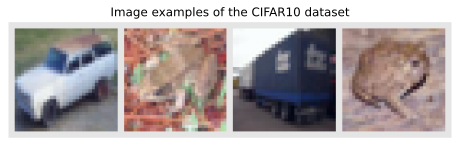

In [3]:
DATASET_PATH = "../data"

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                     ])
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                     ])
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

# Visualize some examples
NUM_IMAGES = 4
CIFAR_images = torch.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(CIFAR_images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the CIFAR10 dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [4]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5) # [B, H', W', C, p_H, p_W]
    x = x.flatten(1,2)              # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2,4)          # [B, H'*W', C*p_H*p_W]
    return x

torch.Size([64, 3, 4, 4])
torch.Size([64, 3, 4, 4])
torch.Size([64, 3, 4, 4])
torch.Size([64, 3, 4, 4])


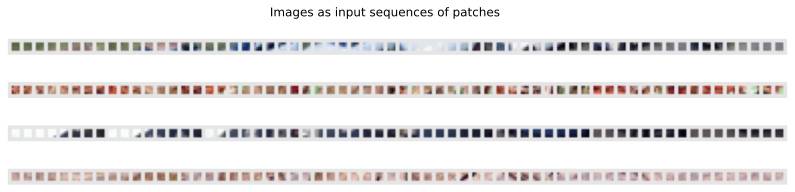

In [5]:
img_patches = img_to_patch(CIFAR_images, patch_size=4, flatten_channels=False)

fig, ax = plt.subplots(CIFAR_images.shape[0], 1, figsize=(14,3))
fig.suptitle("Images as input sequences of patches")
for i in range(CIFAR_images.shape[0]):
    print(img_patches[i].shape)
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=64, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis('off')
plt.show()
plt.close()

## Implementing a transformer from scratch

Your task is to implement the key components of the transformer from scratch. Later, you can just use an existing implementation from huggingface or pytorch.

Check the course for more insights.

In [6]:
class MultiHeadAttention(nn.Module):
    def __init__(self, dmodel, dropout = 0.0, head_dim = 32, qkv_bias=False):
        super().__init__()

        self.dmodel = dmodel
        self.head_dim = head_dim

        # num_heads is dynamic, we compute it based on dmodel and head_dim
        # we want the head dim to be the same regardless of dmodel (see LLaMa paper and other modern architectures)
        self.num_heads = dmodel // head_dim

        # TODO
        self.to_q = nn.Linear(dmodel, dmodel, bias=qkv_bias)
        self.to_k = nn.Linear(dmodel, dmodel, bias=qkv_bias)
        self.to_v = nn.Linear(dmodel, dmodel, bias=qkv_bias)

        self.out_proj = nn.Linear(dmodel, dmodel)  # Optional Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)

        self.scale = head_dim**-0.5

    def forward(self, x):
        b, num_tokens, _ = x.shape

        # Shape: (b, num_tokens, d_out)

        # TODO
        keys = self.to_k(x)
        queries = self.to_q(x)
        values = self.to_v(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # TODO Normalize attention scores by sqrt(dhead) and then compute softmax on the last dim
        attn_weights = F.softmax(attn_scores * self.scale, dim=-1)

        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where dmodel = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.dmodel)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec


In [7]:
class MLP(nn.Module):
    def __init__(self, dmodel, dropout=0.0):
        super().__init__()
        # hidden state is dmodel * 4, it's just a best practice
        hidden_state = dmodel * 4

        self.fc1 = nn.Linear(dmodel, hidden_state)
        self.fc2 = nn.Linear(hidden_state, dmodel)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = F.gelu(x) # gelu, not relu, it works strictly better
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [8]:
class TransformerBlock(nn.Module):
    def __init__(self, dmodel, dropout=0.0, head_dim=32, qkv_bias=False):
        super().__init__()

        self.attn = MultiHeadAttention(dmodel, dropout, head_dim, qkv_bias)
        self.mlp = MLP(dmodel, dropout)

        self.norm1 = nn.LayerNorm(dmodel)
        self.norm2 = nn.LayerNorm(dmodel)

    def forward(self, x):
        # residual connections + layernorms
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

In [9]:
class VisionTransformerEncoder(nn.Module):
    def __init__(self, input_dim, dmodel, n_layers, max_seq_len, n_classes, dropout=0.0, head_dim=32, qkv_bias=False):
        super().__init__()
        self.input_dim = input_dim
        self.dmodel = dmodel
        self.n_layers = n_layers
        self.max_seq_len = max_seq_len
        self.dropout = dropout
        self.head_dim = head_dim
        self.qkv_bias = qkv_bias
        self.n_classes = n_classes

        # preamble, project input data into the transformer dimmension dmodel
        self.input_projection = nn.Linear(input_dim, dmodel)

        # encode positions
        self.absolute_positional_embeddings = nn.Embedding(max_seq_len, dmodel)

        self.layers = nn.ModuleList([
            TransformerBlock(dmodel, dropout, head_dim, qkv_bias)
            for _ in range(n_layers)
        ])

        # add a special token that we're going to use for classification
        self.cls_token = nn.Parameter(torch.zeros(1, 1, dmodel))
        self.classification_output = nn.Linear(dmodel, n_classes)

    def forward(self, x):
        x = img_to_patch(x, patch_size = 4, flatten_channels = True)
        b, num_tokens, _ = x.shape

        # project input data into the transformer dimmension dmodel
        x = self.input_projection(x)

        # add positions
        positions = torch.arange(num_tokens, device = x.device)
        positions = self.absolute_positional_embeddings(positions)
        x = x + positions

        # concatenate the CLS token
        cls_token = self.cls_token.expand(b, -1, -1)
        x = torch.cat((cls_token, x), dim=1)

        # send to transformer
        for layer in self.layers:
            x = layer(x)

        # get the final CLS token from the output
        x = x[:, 0]

        # do the classification
        x = self.classification_output(x)

        return x

In [10]:
def train_epoch(model, dataloader, device, optimizer, criterion, epoch):
    # We set the model to be in training mode
    model.train()

    total_train_loss = 0.0
    dataset_size = 0

    # This is only for showing the progress bar
    bar = tqdm(enumerate(dataloader), total=len(dataloader), colour='cyan', file=sys.stdout)

    # We iterate through all batches - 1 step is 1 batch of batch_size images
    for step, (images, labels) in bar:
        # We take the images and their labels and push them on GPU
        images = images.to(device)
        labels = labels.to(device)

        batch_size = images.shape[0]

        # Reset gradients
        optimizer.zero_grad()

        # Obtain predictions
        pred = model(images)

        # Compute loss for this batch
        loss = criterion(pred, labels)

        # Compute gradients for each weight (backpropagation)
        loss.backward()

        # Update weights based on gradients (gradient descent)
        optimizer.step()

        # We keep track of the average training loss
        total_train_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = np.round(total_train_loss / dataset_size, 2)
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss)

    return epoch_loss

def valid_epoch(model, dataloader, device, criterion, epoch):
    # We set the model in evaluation mode
    model.eval()

    total_val_loss = 0.0
    dataset_size = 0

    # We keep track of correct predictions
    correct = 0

    # This is only for showing the progress bar
    bar = tqdm(enumerate(dataloader), total=len(dataloader), colour='cyan', file=sys.stdout)

    for step, (images, labels) in bar:
        images = images.to(device)
        labels = labels.to(device)

        batch_size = images.shape[0]

        pred = model(images)
        loss = criterion(pred, labels)

        # The raw output of the model is a score for each class
        # We keep the index of the class with the highest score as the prediction
        _, predicted = torch.max(pred, 1)

        # We see how many predictions match the ground truth labels
        correct += (predicted == labels).sum().item()

        # We compute evaluation metrics - loss and accurarcy
        total_val_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = np.round(total_val_loss / dataset_size, 2)

        accuracy = np.round(100 * correct / dataset_size, 2)

        bar.set_postfix(Epoch=epoch, Valid_Acc=accuracy, Valid_Loss=epoch_loss)

    return accuracy, epoch_loss


def run_training(model, num_epochs, learning_rate, trainloader, testloader):
    # Define criterion
    criterion = nn.CrossEntropyLoss()

    # Define optimizer
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    device = torch.device("cuda")
    model.to(device)

    # Check if we are using GPU
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))

    # For keeping track of the best validation accuracy
    top_accuracy = 0.0

    # We train the emodel for a number of epochs
    for epoch in range(num_epochs):

        train_loss = train_epoch(model, trainloader, device, optimizer, criterion, epoch)

        # For validation we do not keep track of gradients
        with torch.no_grad():
            val_accuracy, val_loss = valid_epoch(model, testloader, device, criterion, epoch)
            if val_accuracy > top_accuracy:
                print(f"Validation Accuracy Improved ({top_accuracy} ---> {val_accuracy})")
                top_accuracy = val_accuracy
        print()

In [11]:
vit = VisionTransformerEncoder(
    input_dim = 48, # with patch_size of 4 and 3 channels -> 4*4*3 = 48
    max_seq_len = 64, # 64 patches
    n_classes = 10, # CIFAR-10 has 10 classes
    dmodel = 128, # keep it a power of 2. Try bigger values and see how the accuracy changes. But modify the learning rate accordingly!
    n_layers = 4, # same thing as above
    dropout = 0.01,
    head_dim = 16, # whatever, just don't make it too small (... or too big)
)

summary(vit, input_size = (1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
VisionTransformerEncoder                 [1, 10]                   128
├─Linear: 1-1                            [1, 64, 128]              6,272
├─Embedding: 1-2                         [64, 128]                 8,192
├─ModuleList: 1-3                        --                        --
│    └─TransformerBlock: 2-1             [1, 65, 128]              --
│    │    └─LayerNorm: 3-1               [1, 65, 128]              256
│    │    └─MultiHeadAttention: 3-2      [1, 65, 128]              65,664
│    │    └─LayerNorm: 3-3               [1, 65, 128]              256
│    │    └─MLP: 3-4                     [1, 65, 128]              131,712
│    └─TransformerBlock: 2-2             [1, 65, 128]              --
│    │    └─LayerNorm: 3-5               [1, 65, 128]              256
│    │    └─MultiHeadAttention: 3-6      [1, 65, 128]              65,664
│    │    └─LayerNorm: 3-7               [1, 65, 128]         

In [ ]:
# You may want to change the hyperparameters to obtain better results
run_training(model=vit, num_epochs = 10, learning_rate=0.001, trainloader = train_loader, testloader = val_loader)

AssertionError: Torch not compiled with CUDA enabled

: 

In [ ]:
# Other TODOs

# 1. Instead of our hand-made attention mechanism, try to incorporate the optimized version from PyTorch
# https://pytorch.org/docs/stable/generated/torch.nn.functional.scaled_dot_product_attention.html

# 2. Instead of our hand-made transformer, try to incorporate the TransformerEncoder class from PyTorch
# https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html
# Make sure to do the same things as we did to make it work for image classification: position embeddings, cls token, patchification etc.

class VisionTransformerEncoderOptimized(nn.Module):
    def __init__(self, input_dim, dmodel, n_layers, max_seq_len, n_classes, dropout=0.0, head_dim=32, qkv_bias=False):
        super().__init__()
        self.input_dim = input_dim
        self.dmodel = dmodel
        self.n_layers = n_layers
        self.max_seq_len = max_seq_len
        self.dropout = dropout
        self.head_dim = head_dim
        self.qkv_bias = qkv_bias
        self.n_classes = n_classes

        # preamble, project input data into the transformer dimension dmodel
        self.input_projection = nn.Linear(input_dim, dmodel)

        # encode positions
        self.absolute_positional_embeddings = nn.Embedding(max_seq_len, dmodel)

        # Transformer Encoder Layer
        encoder_layer = nn.TransformerEncoderLayer(d_model=dmodel, nhead=dmodel // head_dim, dim_feedforward=dmodel * 4, dropout=dropout, activation='gelu')
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # add a special token that we're going to use for classification
        self.cls_token = nn.Parameter(torch.zeros(1, 1, dmodel))
        self.classification_output = nn.Linear(dmodel, n_classes)

    def forward(self, x):
        x = img_to_patch(x, patch_size=4, flatten_channels=True)
        b, num_tokens, _ = x.shape

        # project input data into the transformer dimension dmodel
        x = self.input_projection(x)

        # add positions
        positions = torch.arange(num_tokens, device=x.device)
        positions = self.absolute_positional_embeddings(positions)
        x = x + positions

        # concatenate the CLS token
        cls_token = self.cls_token.expand(b, -1, -1)
        x = torch.cat((cls_token, x), dim=1)

        # send to transformer
        x = self.transformer_encoder(x)

        # get the final CLS token from the output
        x = x[:, 0]

        # do the classification
        x = self.classification_output(x)

        return x

# Instantiate the optimized Vision Transformer
vit_optimized = VisionTransformerEncoderOptimized(
    input_dim=48,  # with patch_size of 4 and 3 channels -> 4*4*3 = 48
    max_seq_len=64,  # 64 patches
    n_classes=10,  # CIFAR-10 has 10 classes
    dmodel=128,  # keep it a power of 2. Try bigger values and see how the accuracy changes. But modify the learning rate accordingly!
    n_layers=4,  # same thing as above
    dropout=0.01,
    head_dim=16,  # whatever, just don't make it too small (... or too big)
)

summary(vit_optimized, input_size=(1, 3, 32, 32))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

[INFO] Using GPU: Tesla T4



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Validation Accuracy Improved (0.0 ---> 10.02)



  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/351 [00:00<?, ?it/s]

KeyboardInterrupt: 